# About the dataset
20k hotel reviews extracted from Tripadvisor.

Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged.
With this dataset, consisting of 20k reviews crawled from Tripadvisor, you can explore what makes a great hotel and maybe even use this model in your travels!

* Predict Review Rating
* Topic Modeling on Reviews
* Explore key aspects that make hotels good or bad

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')


/Users/anastasiyaigonina/miniconda3/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiyaigonina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anastasiyaigonina/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anastasiyaigonina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anastasiyaigonina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [4]:
# Load the dataset
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# Rating distribution

In [5]:
# Check counts of all rating
df['Rating'].value_counts(normalize=True)

Rating
5    0.441853
4    0.294715
3    0.106583
2    0.087502
1    0.069348
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Count of reviews by rating')

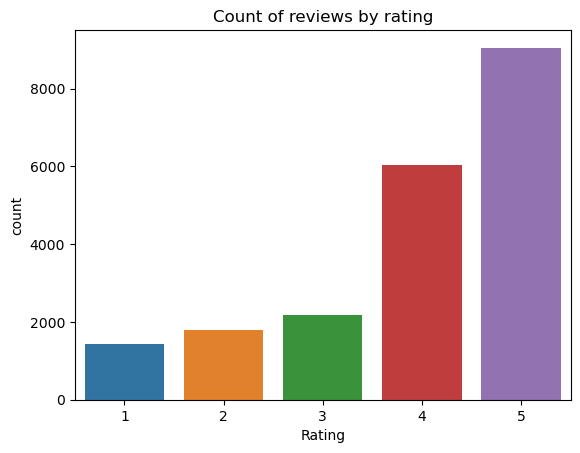

In [6]:
# Visualize rating distribution
sns.countplot(data=df, x='Rating')
plt.title('Count of reviews by rating')

# Review length

In [7]:
# Count length of the reviews
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


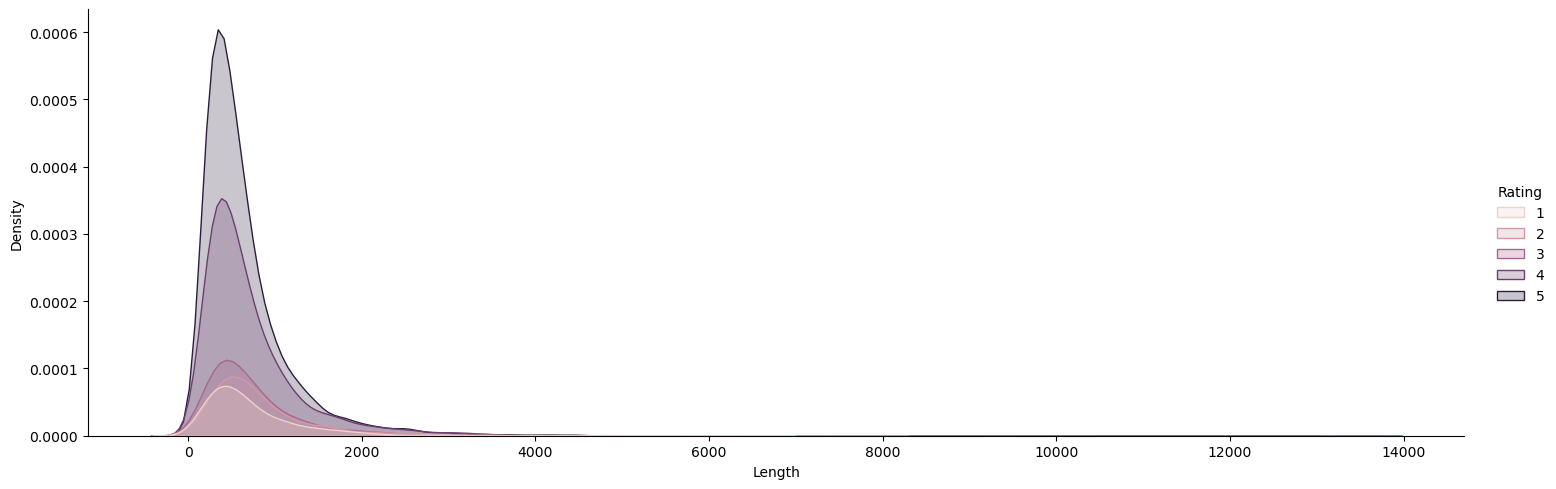

In [8]:
# Visualize length distribution based on the rating
sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=3)

# Text preprocessing

In [9]:
# Define a function to clean the text
def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1\1+', r"\1\1", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w) > 2]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    
    text = ' '.join(tokens)
    return text

# Apply new function
df['Review'] = df['Review'].apply(clean_text)


# 20 most common words

In [10]:
# Find the most common words
all_words = ' '.join(df['Review']).lower().split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)

print(top_words)

[('hotel', 52900), ('room', 46357), ('great', 21095), ('good', 17060), ('staff', 16285), ('stay', 15339), ('night', 14073), ('day', 12952), ('time', 12601), ('nice', 12409), ('location', 11234), ('service', 10533), ('stayed', 10469), ('restaurant', 10090), ('beach', 10043), ('breakfast', 9654), ('place', 9381), ('clean', 9372), ('food', 9255), ('resort', 8918)]


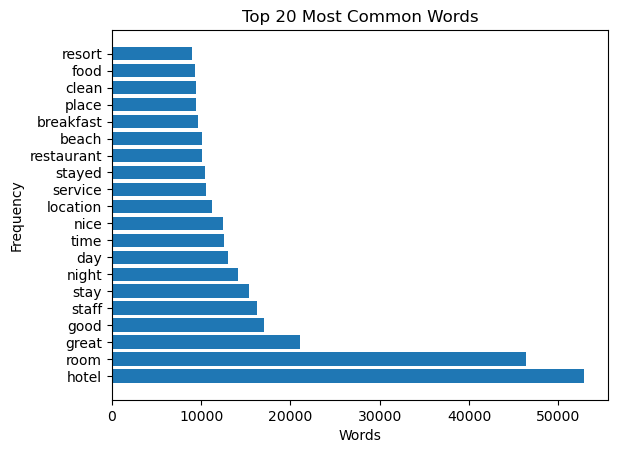

In [11]:
# Visualize most common words
fig, ax = plt.subplots()
ax.barh([word for (word, count) in top_words], [count for (word, count) in top_words])
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Most Common Words')
plt.show()

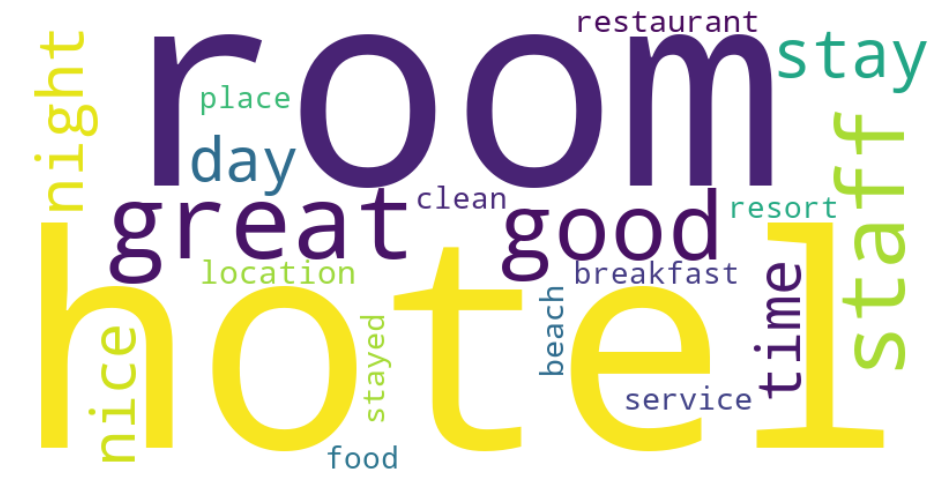

In [12]:
# Create a word cloud
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white').generate_from_frequencies(dict(top_words))

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment Analysis
We will perform sentiment analysis to analyze sentiment of each review and classify it as positive, negative, or neutral. 
And results will be compared with the real rating of the hotel. 


In [13]:
# Define a function to classify the sentiment of a review
sia = SentimentIntensityAnalyzer()

def get_sentiment(review):
    scores = sia.polarity_scores(review)
    sentiment_score = scores['compound']
    if sentiment_score > 0.1:
        return 'positive'
    elif sentiment_score < -0.1:
        return 'negative'
    else:
        return 'neutral'
    
# Apply function on dataset copy
df2 = df.copy()
df2['Predicted_Sentiment'] = df2['Review'].apply(get_sentiment)

# Print the number of positive, negative, and neutral reviews
print("Number of positive reviews:", len(df2[df2['Predicted_Sentiment'] == 'positive']))
print("Number of negative reviews:", len(df2[df2['Predicted_Sentiment'] == 'negative']))
print("Number of neutral reviews:", len(df2[df2['Predicted_Sentiment'] == 'neutral']))

Number of positive reviews: 19305
Number of negative reviews: 1045
Number of neutral reviews: 141


In [14]:
# Map the rating column to create new column true sentiment
df2['True_Sentiment'] = df2['Rating'].map({1: 'negative', 
                                           2: 'negative', 
                                           3: 'neutral', 
                                           4: 'positive', 
                                           5: 'positive'})

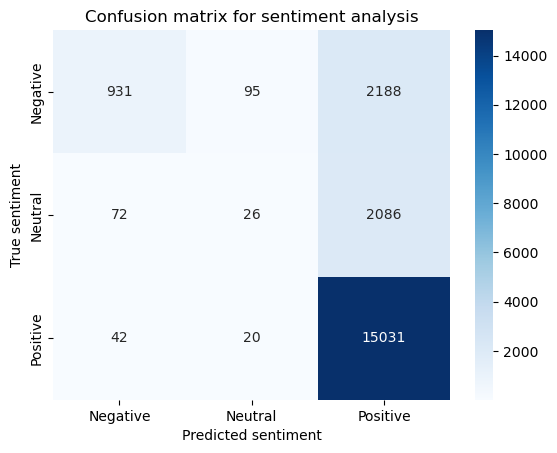

In [15]:
# Calculate confusion matrix
cm = confusion_matrix(df2['True_Sentiment'], df2['Predicted_Sentiment'])

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.title('Confusion matrix for sentiment analysis')
plt.show()

In [16]:
print("\nClassification report:\n", classification_report(df2['True_Sentiment'], 
                                                          df2['Predicted_Sentiment']))


Classification report:
               precision    recall  f1-score   support

    negative       0.89      0.29      0.44      3214
     neutral       0.18      0.01      0.02      2184
    positive       0.78      1.00      0.87     15093

    accuracy                           0.78     20491
   macro avg       0.62      0.43      0.44     20491
weighted avg       0.73      0.78      0.71     20491



Hence, we performed sentiment analysis on the review column with 78% accuracy. 

# Prediction of Rating
In this section, we will use a pre-trained sentiment analysis model and then predict hotel rating based on the review. 

In [17]:
# Define function for new column sentiment
positive = [4, 5]
neutral = [3]
negative = [1, 2]

def map_sentiment(rating):
    if rating in positive:
        return 2
    elif rating in neutral:
        return 1
    else:
        return 0

df['Sentiment']= df['Rating'].apply(map_sentiment)

In [18]:
# Prepare data for modeling
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(df['Review'])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=24)

/Users/anastasiyaigonina/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Random Forest

In [19]:
# Build the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predicted_rf = rf.predict(X_test)

# Calculate accuracy and print classification report
accuracy_rf = accuracy_score(y_test, predicted_rf)
print('Accuracy:', accuracy_rf)
print('Classification Report:')
print(classification_report(y_test, predicted_rf))


Accuracy: 0.8053874682803045
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.48      0.62       810
           1       0.67      0.01      0.01       565
           2       0.80      1.00      0.89      3748

    accuracy                           0.81      5123
   macro avg       0.79      0.49      0.51      5123
weighted avg       0.80      0.81      0.75      5123



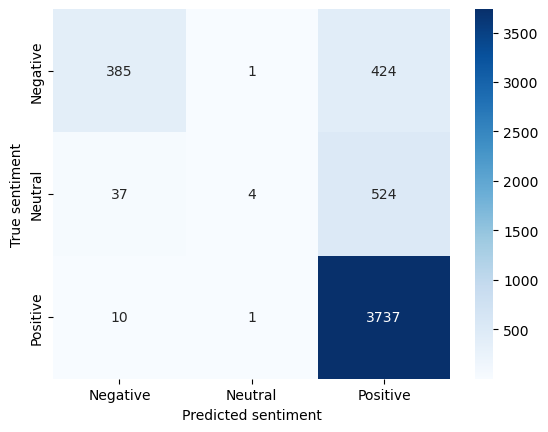

In [20]:
# Build confusion matrix
cm_rf = confusion_matrix(y_test, predicted_rf)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# Naive Bayes Multinominal

In [21]:
# Build the model
nb = MultinomialNB()
nb.fit(X_train, y_train)

predicted_nb = nb.predict(X_test)

# Calculate accuracy and print classification report 
accuracy_nb = accuracy_score(y_test, predicted_nb)
print('Accuracy:', accuracy_nb)
print('Classification Report:')
print(classification_report(y_test, predicted_nb))

Accuracy: 0.8210033183681437
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.60      0.70       810
           1       1.00      0.00      0.00       565
           2       0.82      0.99      0.90      3748

    accuracy                           0.82      5123
   macro avg       0.88      0.53      0.53      5123
weighted avg       0.84      0.82      0.77      5123



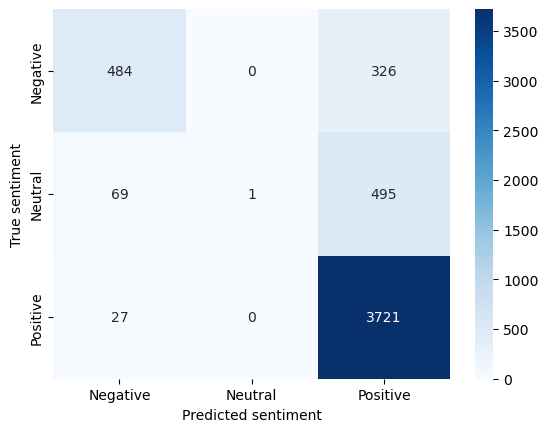

In [22]:
# Build confusion matrix
cm_nb = confusion_matrix(y_test, predicted_nb)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# XGBoost

In [23]:
# Build the model
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

predicted_xgb = xgb.predict(X_test)

# Calculate accuracy and print classification report 
accuracy_xgb = accuracy_score(y_test, predicted_xgb)
print('Accuracy:', accuracy_xgb)
print('Classification Report:')
print(classification_report(y_test, predicted_xgb))

Accuracy: 0.8393519422213547
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       810
           1       0.50      0.14      0.22       565
           2       0.86      0.98      0.92      3748

    accuracy                           0.84      5123
   macro avg       0.72      0.60      0.62      5123
weighted avg       0.81      0.84      0.81      5123



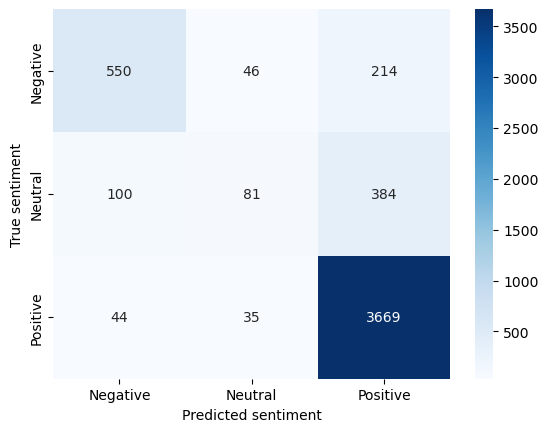

In [24]:
# Build confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_xgb)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# Logistic Regression

In [25]:
# Build model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_lr = accuracy_score(y_test, predicted_lr)
print('Accuracy:', accuracy_lr)
print('Classification Report:')
print(classification_report(y_test, predicted_lr))

Accuracy: 0.8483310560218622
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       810
           1       0.50      0.12      0.19       565
           2       0.87      0.98      0.92      3748

    accuracy                           0.85      5123
   macro avg       0.72      0.61      0.62      5123
weighted avg       0.82      0.85      0.82      5123



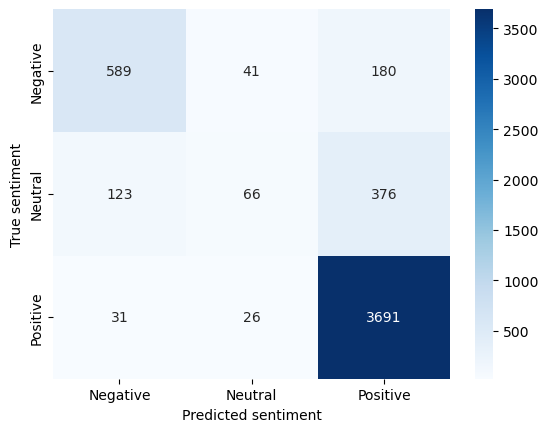

In [26]:
# Build confusion matrix
cm_lr = confusion_matrix(y_test, predicted_lr)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# Linear Support Vector Classification

In [27]:
# Build model
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)

predicted_svc = svc.predict(X_test)

# Calculate accuracy and print classification report
accuracy_svc = accuracy_score(y_test, predicted_svc)
print('Accuracy:', accuracy_svc)
print('Classification Report:')
print(classification_report(y_test, predicted_svc))

Accuracy: 0.8477454616435682
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       810
           1       0.42      0.20      0.28       565
           2       0.89      0.97      0.93      3748

    accuracy                           0.85      5123
   macro avg       0.69      0.64      0.65      5123
weighted avg       0.82      0.85      0.83      5123



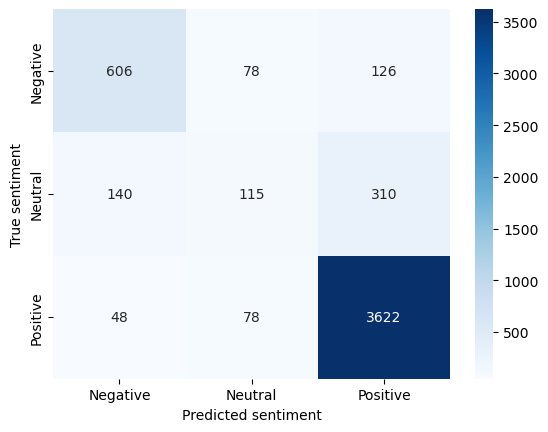

In [28]:
# Build confusion matrix
cm_svc = confusion_matrix(y_test, predicted_svc)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

In [29]:
# Compare models performance
Models = ['Random Forest', 'Naive Bayes Multinominal', 'XGBoost', 'Logistic Regression', 'SVC']
Scores = [accuracy_rf, accuracy_nb, accuracy_xgb, accuracy_lr, accuracy_svc]
performance = pd.DataFrame(list(zip(Models, Scores)), 
                          columns = ['Models', 'Accuracy_score'])\
                            .sort_values('Accuracy_score', ascending=False)
performance

,Models,Accuracy_score
3,Logistic Regression,0.848331
4,SVC,0.847745
2,XGBoost,0.839352
1,Naive Bayes Multinominal,0.821003
0,Random Forest,0.805387


As we can see, the best-performing models are SVC and Logistic Regression with an accuracy score of almost 85%.

# Topic modeling
Topic modeling algorithms, such as Latent Dirichlet Allocation (LDA), are a type of unsupervised learning method that helps to identify patterns in large amounts of unstructured text data. 

It can be used to identify the primary and hidden topics that appear in the reviews. 

In [30]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

In [31]:
#Prepare data for topic modeling
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess the reviews
def preprocess(review):
    review = review.lower()
    tokens = nltk.word_tokenize(review)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Apply preprocessing to the reviews
reviews = [preprocess(review) for review in df['Review']] 


In [32]:
# Create a dictionary and corpus for the reviews
dictionary = corpora.Dictionary(reviews)
corpus = [dictionary.doc2bow(review) for review in reviews]

# Train an LDA model on the corpus
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)

# Print the topics and the top words for each topic
for topic in lda_model.show_topics(num_topics=5):
    print('Topic', topic[0])
    print('Top words:', topic[1], '\n')

Topic 0
Top words: 0.034*"room" + 0.025*"hotel" + 0.010*"stay" + 0.009*"service" + 0.009*"night" + 0.008*"time" + 0.008*"staff" + 0.006*"day" + 0.006*"floor" + 0.005*"like" 

Topic 1
Top words: 0.014*"room" + 0.013*"beach" + 0.013*"resort" + 0.011*"day" + 0.010*"food" + 0.010*"pool" + 0.010*"time" + 0.009*"good" + 0.008*"great" + 0.007*"people" 

Topic 2
Top words: 0.054*"hotel" + 0.026*"room" + 0.019*"great" + 0.015*"staff" + 0.013*"stay" + 0.013*"location" + 0.010*"good" + 0.009*"stayed" + 0.009*"breakfast" + 0.008*"clean" 

Topic 3
Top words: 0.019*"beach" + 0.019*"villa" + 0.013*"pool" + 0.011*"bali" + 0.010*"room" + 0.007*"nice" + 0.006*"hotel" + 0.006*"place" + 0.005*"great" + 0.005*"ocean" 

Topic 4
Top words: 0.028*"room" + 0.027*"hotel" + 0.012*"good" + 0.010*"nice" + 0.010*"great" + 0.008*"night" + 0.007*"free" + 0.007*"bed" + 0.006*"area" + 0.006*"breakfast" 



In [33]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/var/folders/ln/yr5kx06d4c5bnvw8yt79qcqc0000gn/T/ipykernel_15854/2978676153.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [34]:
# Visualize the topics using pyLDAvis
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


In [35]:
# Save html file
pyLDAvis.save_html(vis, 'lda_results.html')

# Text clustering for negative reviews
We can use text clustering algorithms, such as K-means, to group similar reviews into clusters based on the similarity of their contents. The goal of clustering is to identify underlying patterns or structures in the data, which can be useful for recommendation systems, for example improving customer service.

In [36]:
# Choose only negative reviews
df_neg = df[df['Rating'] <= 2]

# Convert text to numerical vectors using TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_neg['Review'])

# Cluster the documents using K-Means algorithm
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

# Evaluate the performance of the clustering using adjusted Rand index
y_true = df_neg['Rating'].values
y_pred = kmeans.labels_
print('Adjusted Rand index:', adjusted_rand_score(y_true, y_pred))

Adjusted Rand index: 0.019169739451700297


In [37]:
# Reduce the dimensionality of the vectors to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [38]:
# Print the top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i+1} top terms:", [terms[ind] for ind in order_centroids[i, :10]])
    print('-------')

Cluster 1 top terms: ['room', 'hotel', 'stay', 'night', 'service', 'told', 'desk', 'day', 'time', 'staff']
-------
Cluster 2 top terms: ['hotel', 'room', 'stay', 'location', 'night', 'staff', 'good', 'bed', 'place', 'stayed']
-------
Cluster 3 top terms: ['resort', 'beach', 'food', 'room', 'day', 'pool', 'restaurant', 'time', 'service', 'good']
-------


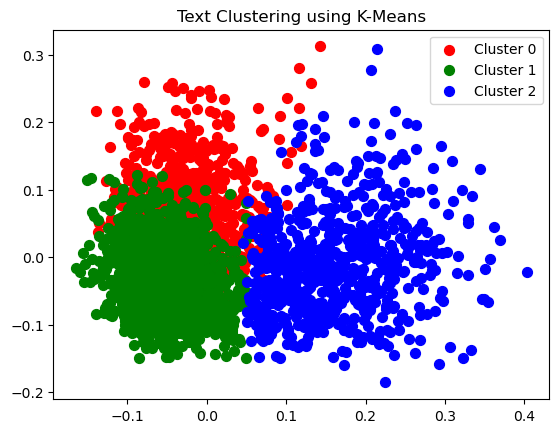

In [39]:
# Plot the clusters
colors = ['red', 'green', 'blue']
for i in range(num_clusters):
    plt.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], s=50, c=colors[i], label='Cluster {}'.format(i))
plt.legend()
plt.title('Text Clustering using K-Means')
plt.show()

In [40]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

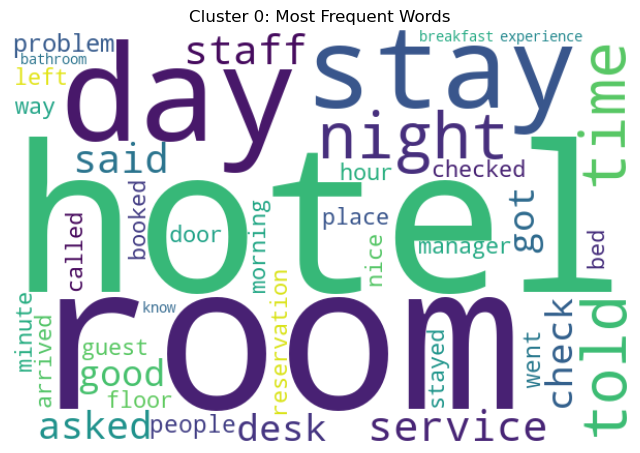

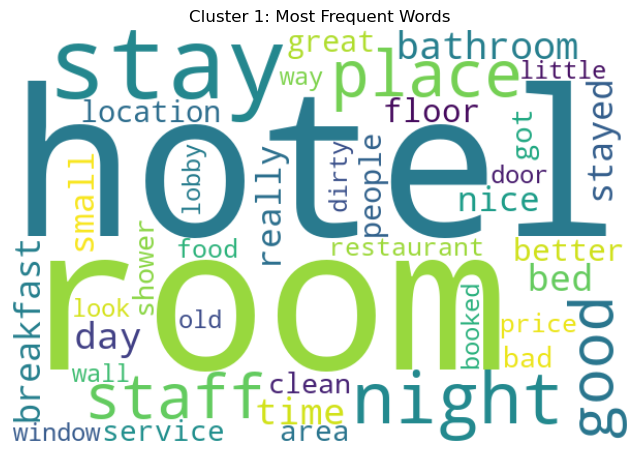

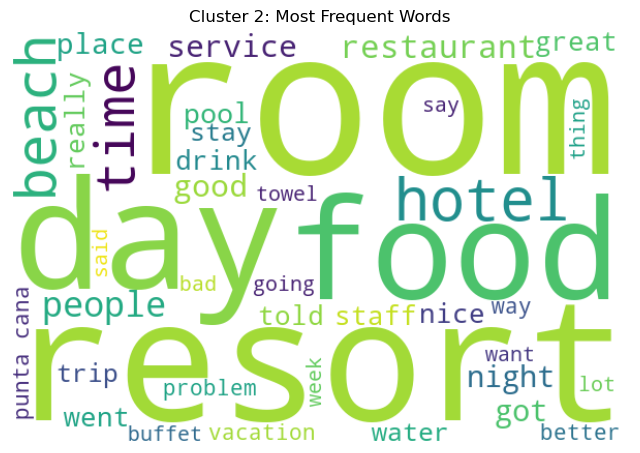

In [41]:
# Get the most frequent words in each cluster
top_words = 40
for i in range(num_clusters):
    cluster_reviews = df_neg['Review'][kmeans.labels_ == i]
    cluster_text = ' '.join(cluster_reviews)
    wordcloud = WordCloud(width=600, height=400, max_words=top_words, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Cluster {}: Most Frequent Words'.format(i))
    plt.show()

### Thank you for reading!